# ``Sequence-Space Jacobians of Life Cycle Models,'' a Demonstration

This notebook is a demonstration of the method and objects presented in [``Sequence-Space Jacobians of Life Cycle Models''](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5274675) by Bence Bardoczy and Mateo Velasquez-Giraldo. The repository contains an implementation of the method and code to reproduce the results presented in the paper. The goal of this notebook is to provide an interactive illustration of how to work with the different objects that the paper defines. The final section of the notebook also demonstrates how to integrate the Jacobians that we calculate with the [sequence-jacobian](https://github.com/shade-econ/sequence-jacobian) package, to perform dynamic analyses of equilibrium relationships between multiple model blocks.

If you find the paper or the code in this repository useful, please cite the paper. Here is a suggested .bib entry:
```
@online{bardoczy_sequence-space_2025,
  type = {SSRN Scholarly Paper},
  title = {Sequence-{{Space Jacobians}} of {{Life Cycle Models}}},
  author = {Bardoczy, Bence and Velasquez Giraldo, Mateo},
  date = {2025-05-29},
  number = {5274675},
  eprint = {5274675},
  eprinttype = {Social Science Research Network},
  location = {Rochester, NY},
  url = {https://papers.ssrn.com/abstract=5274675},
  urldate = {2025-05-29},
  langid = {english},
  pubstate = {prepublished},
  keywords = {General Equilibrium,Heterogeneous Agent Models,Life Cycle Dynamics,Sequence Space Jacobians},
}
```

[a notation conondrum in this notebook is that `a` often denotes "assets" in macro models, but it is also a natural choice for age. The code calls assets "a" but, in the notebook's equations and text, "a" means age and we re-label assets as "b"...sorry]

In [1]:
export_plots = False
plot_dir = "../Slides/Figs/"

# Model Description

We concentrate on a life-cycle household block with exactly the same characteristics defined in [``Sequence-Space Jacobians of Life Cycle Models''](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5274675). At the end of the note, we show how to define the Jacobians we calculate as objects that the [sequence-jacobian](https://github.com/shade-econ/sequence-jacobian/tree/master) package will recognize. This makes it possible to place the life-cycle model in a greater macroeconomic environment and to analyze the dynamics of the resulting overlapping-generations economy. 

A summary of the life cycle household block is:
- Households live from age 26 to a maximum of 100. Time advances in years.
- They face age-specific probabilities of dying, $\delta_a$.
- They work exogenously until age 65 and then they retire.
- In their working years, they receive income $y_{i,a} = \exp\{f_a + z_{i,a}\}\times w$. Here:
  - $f_a$ is an age-fixed effect calibrated to match the age profile of income in the 2019 Survey of Consumer Finances.
  - $z_{i,a}$ is an idiosyncratic productivity shock that follows a discretized AR(1) proces.
  - $w$ is the economy-wide wage rate.
- In their retirement years, they receive income $y_{i,a} = \exp\{f_a + z_{i,65}\}\times \phi$.
  - We follow the common practice of indexing pension income to the productivity shock in agent's last working period.
  - $\phi$ is an economy-wide multiplier of pensions.
- Income (including pensions) is taxed at a rate $\tau$.
- Every year, agents decide how much to consume. They save to insure against shocks and to prepare for retirement.
- Savings earn a risk-free return factor $R$.


The Bellman equation of a working age household is
\begin{equation}
    \begin{split}
		V_a(z_{i,a}, b_{i,a-1}) =& \max_{c_{i,a}} \frac{c_{i,a}^{1-\rho}}{1-\rho} + \beta (1-\delta_a) \mathbb{E} \left[ V_{a+1}\left(z_{i,a+1}, b_{i,a}\right) \right]\\
		\text{Subject to:}&\\
		b_{i,a} =& R \times b_{i,a-1} + (1-\tau)y_{i,a} - c_{i,a},\\
        y_{i,a} =& \exp\{f_a + z_{i,a}\}\times w,\\
		b_{i,a}\geq & 0,\\
        z_{i,a+1}\sim& \Pi(z_{i,a}).
	\end{split}
\end{equation}

# Computational Representation and Steady State Analysis

The household block is implemented as an class of the [HARK](https://github.com/econ-ark/HARK) toolkit. We have called this class "SimpleNKAgent." The class contains general versions of methods like a single-period backward solution or the calculation of a single-period transition matrix. These same methods are used in both infinite horizon and life-cycle versions of the model. You can find the definition of the class in the file [`Tools/SimpleNKAgent.py`](https://github.com/Mv77/LC-SSJ_public/blob/main/Tools/SimpleNKAgent.py).

To create a particular version of our simple model---with a given income path, preferences, length of life, etc---we instantiate the class. We do so by passing the particular parameters that configure our specific version of the model. We pre-lodaded those in a dictionary called `params`, defined in the file [`defs.py`](https://github.com/Mv77/LC-SSJ_public/blob/main/defs.py). With that, we can create our agent.

In [2]:
from Tools.SimpleNKAgent import SimpleNKAgent
from defs import params

# Create agent instantiating the SimpleNKAgent class
agent = SimpleNKAgent(**params)

Next, we need to solve the model. This entails using backward iteration to find the optimal policy vectors, value functions, and transition matrices associated with the parametrization we have used.

In [``Sequence-Space Jacobians of Life Cycle Models''](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5274675), we think of the life-cycle implementation of a model as a function that transforms sequences of inputs (wages, interest rates, taxes, etc) that the agent faces at every age to sequences of policy vectors, value vectors, and transition matrices associated with every age.
\begin{equation*}
    \{y(a), v(a), \mathcal{L}(a)\}_{a=0}^{A-1} = \texttt{solve}(\{X_a\}_{a=0}^{A-1})
\end{equation*}

The `SimpleNKAgent` class and its `solve` method are our way to represent this function. You might come up with your own improvement.

The $\{X_a\}_{a=0}^{A-1}$ inputs are in the `params` object. Our `agent` object already has them incorporated.

Now we solve the model by backward iteration.

In [3]:
# Create the initial condition for backward iteration (a dummy terminal period solution)
agent.update_solution_terminal()
# and then run backward iteration
agent.solve(verbose=True)

Finished cycle #1 of 1 in 0.5611667633056641 seconds.


The solve methods creates the property `agent.solution`, which is a list with one entry per age. Each entry is a solution object that contains the vectors $(\{y(a), v(a)\}_{a=0}^{A-1})$ and transition matrices ($\{\mathcal{L}(a)\}_{a=0}^{A-1}$) that we need.

In [4]:
print("The solution object has {} entries.".format(len(agent.solution)))
print("The upper-left 5x5 block of the 'policy vector' for consumption at age 3 is:")
print(agent.solution[3].outcomes['c'][:4,:4])
print("The upper-left 5x5 block of the 'value vector' (that is actually dvda) age 5 is:")
print(agent.solution[5].vfunc['dvda'][:4,:4])

print("We can also access the transition matrix for age 5, which has a specialized representation:")
print(agent.solution[5].tmat)

The solution object has 76 entries.
The upper-left 5x5 block of the 'policy vector' for consumption at age 3 is:
[[0.41149248 0.41159448 0.44878051 0.47072257]
 [0.48448674 0.48458874 0.52255008 0.54468299]
 [0.57042938 0.57053138 0.60899266 0.63122587]
 [0.6716173  0.6717193  0.71029837 0.73249698]]
The upper-left 5x5 block of the 'value vector' (that is actually dvda) age 5 is:
[[4.89844844 4.8962593  4.18733232 3.84017604]
 [3.53360953 3.5322682  3.08482878 2.86234559]
 [2.54905128 2.54822943 2.2689129  2.12772587]
 [1.83881734 1.83831378 1.66688327 1.57977554]]
We can also access the transition matrix for age 5, which has a specialized representation:


What on earth is this `NKtmat` object?

A transition matrix $\mathcal{L}(a)$ in our context must represent the distribution of $(z_{i,a+1},b_{i,a})$ given $(z_{i,a}, b_{i,a-1})$ so that if $D(a)$ is a distribution of agents over a bivariate $(z_{i,a}, b_{i,a-1})$ grid, then $D(a+1) = \mathcal{L(a)}'D(a)$ is the distribution over a $(z_{i,a+1},b_{i,a})$ grid that would be consistent with our model.

Notice, however, that productivity $z_{a+1}$ is independent of any choice the agent makes at age $a$. Thus
\begin{equation*}
    P(z_{i,a+1},b_{i,a}|z_{i,a},b_{i,a-1}) = \underbrace{P(b_{i,a}|z_{i,a},b_{i,a-1})}_{\text{{
        Asset Transition}}}\times \underbrace{P(z_{i,a+1}|z_{i,a})}_{\text{Prod. Transiton}}.
\end{equation*}

Of these two mathematically equivalent ways to track state-to-state transitions, the right hand side is more compact (easier to store) and faster for taking expectations and advancing distributions, which is what we will need.

`NKtmat` is an object that behaves as a full transition matrix, with "expect" and "advance" methods, but internally stores and uses the asset and productivity transitions separately instead of the full matrix.  

In [5]:
print('Asset transition in age 5 has dimensions:')
print(agent.solution[5].tmat.a_tmat.shape)
print('Productivity transition in age 5 has dimensions:')
print(agent.solution[5].tmat.z_tmat.shape)

Asset transition in age 5 has dimensions:
(7, 51, 51)
Productivity transition in age 5 has dimensions:
(7, 7)


Now, we construct the agent's "transitions" property. This is a wrapper that collects the single-period transition matrices and death probabilities; it provides convenient methods to, for example, iterate a population of agents forward in time, or find the steady state distribution of agents. This object depends on our assumption about the distribution that newborns draw their states from. We have also pre-defined this as an object called `nb_dstn`.

In [6]:
# Now we build the transitions, which depend on the newborn distribution.
from defs import nb_dstn
agent.build_transitions(newborn_dstn=nb_dstn)

Now we can start inspecting the transition properties and the solution.

First, lets calculate the steady state distribution.

In [7]:
# Get the steady state distribution
ss_dstn = agent.transitions.find_steady_state_dstn()
# This is a list of arrays, one for each age, containing the steady state distribution of agents of that age.
# arrays have the same dimensions as the age-specific state space and their entries are the mass of agents in that state.
print("The SS Distribution has {} entries.".format(len(ss_dstn)))

The SS Distribution has 76 entries.


A first thing we can look at is the demographic structure of the household block.

Total mass of agents: 0.9999999999999947


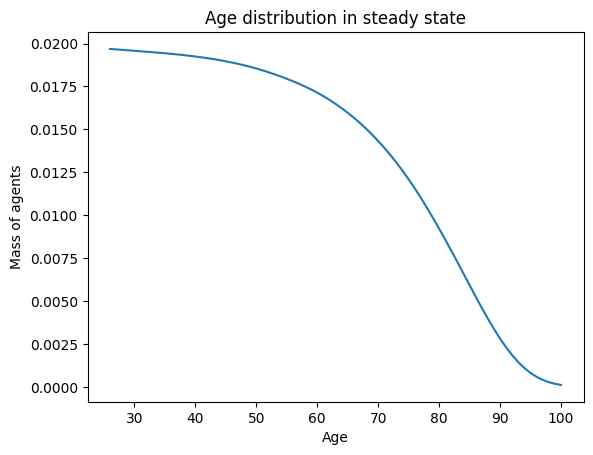

In [8]:
# Pre-load a vector with the ages of our calibration (this is just [26, 27,...,100])
# just for plotting purposes
from defs import age_vec

# Sum and plot the mass of agents of every age
import numpy as np
age_mass = np.array([x.sum() for x in ss_dstn])

import matplotlib.pyplot as plt
# Remove the dummy terminal period solution
plt.plot(age_vec, age_mass[:-1])
plt.xlabel('Age')
plt.ylabel('Mass of agents')
plt.title('Age distribution in steady state')

# Confirm that the mass of agents is 1
print(f'Total mass of agents: {age_mass.sum()}')

## What interesting dynamics does the life cycle introduce?

One of them is saving for retirement. Franco Modigliani's ``Life Cycle Hypothesis of Saving'' says that if a household expects its income to be lower during retirement, it will save during its working life and deccumulate its buffer of assets during retirement, smoothing its consumption.

In a simple model where a household lives for $L$ years, works for $N<L$ years earning $Y(t)$ in year $t$, receives no retirement benefits, and does not discount the future or earn interest on its savings, the household sets its consumption every year to
\begin{equation*}
C = \frac{\sum_{t=0}^{N-1} Y(t)}{L} = \frac{N \times \bar{Y}}{L}.
\end{equation*}
The next figure illustrates that consumption-saving plan from the original paper.

![alt text](Modigliani.png)

`Modigliani, F. (1986). Life cycle, individual thrift, and the wealth of nations. Science, 234(4777), 704-712.`


Our model adds various ingredients to this example: stochastic mortality, stochastic income, borrowing constraints, impatience that is not exactly offset by interest rates. Can we still get something that looks similar?

In [9]:
# We can first extract some policy vector points from our solution. This is done with
# the method "get_outcomes." It formats policy points like our distributions from before:
# lists with one array per year, each array with one point per state configuration.

# Find the policy points for consumption, income, and start-of-period assets
outs = ["c", "income", "a_sop"]
out_points = agent.get_outcomes(outs)

C:\Users\mateo\AppData\Local\Temp\ipykernel_4956\3827746878.py:5: RuntimeWarning: invalid value encountered in divide


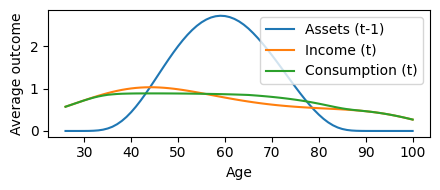

In [10]:
# Lets plot the average outcomes conditional on age.

# Find averages of all outcomes
avgs = {
    k: np.array([np.divide(np.sum(p * d), d.sum()) for p, d in zip(points, ss_dstn)])
    for k, points in out_points.items()
}

# Plot
fig = plt.figure(figsize=(4.5, 2))
labels = {'a_sop' : 'Assets (t-1)', 'c' : 'Consumption (t)', 'income' : 'Income (t)'}
for out in ['a_sop', 'income', 'c']:
    # Again, drop the terminal dummy solution
    plt.plot(age_vec, avgs[out][:-1], label=labels[out])
plt.xlabel('Age')
plt.ylabel('Average outcome')
plt.legend()
fig.tight_layout()

if export_plots:
    plt.savefig(plot_dir + "age_profiles.pdf")

We do get something similar to the original life cycle hypothesis paper: Consumption is smoother than income, people save in their working years and deplete those savings as they age.

Just to make sure we are getting some heterogeneity, let's look at the standard deviation of age-specific consumption over the life cycle.

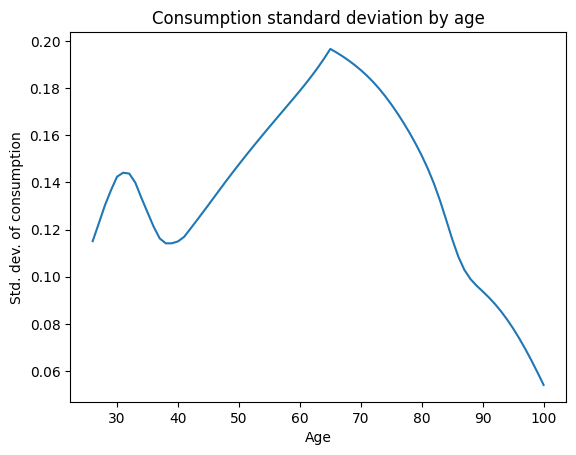

In [11]:
def weighted_std(data, weights):
    average = np.average(data, weights=weights)
    variance = np.average((data - average) ** 2, weights=weights)
    return np.sqrt(variance)

c_std = np.array([
    weighted_std(points.flatten(), d.flatten())
    for points, d in zip(out_points['c'][:-1], ss_dstn[:-1])
])

plt.figure()
plt.plot(age_vec, c_std)
plt.xlabel('Age')
plt.ylabel('Std. dev. of consumption')
plt.title('Consumption standard deviation by age')
plt.show()


# Jacobians and Fake News Matrices of the Household Block

Now let's compute the fake news matrices and jacobians of our household block. The paper outlines a method to compute them for life cycle blocks like ours. We implemented this version of the method (along with the original SSJ method for infinite horizon models) in the file [`Tools/seq_jacobian.py`](https://github.com/Mv77/LC-SSJ_public/blob/main/Tools/seq_jacobian.py). Here we can just import it and apply it.

We can think of many macroeconomically relevant inputs and outputs. For our exercises, we explore:
- Outputs: consumption `c` and assets `b` (which are unfortunately denoted `a` in the code, but here we are using $a$ for age).
- Inputs: the  the tax rate on income $\tau$, and the multiplier on pensions $\phi$.

Instead of $\tau$ and $\phi$ being constant like in our model statement, they will become time varying. From the perspective of a particular cohort, this implies they solve their dynamic problem with age-varying parameters $\{\tau_a,\phi_a\}_{a=26}^{100}$. These sequences will be different for each cohort of agents.

Just as a refresher, the objects we want to compute are **Age-Specific Sequence-Space Jacobians**:
\begin{equation*}
    \left\{\mathcal{J}^{C,\tau}(a)\right\}_{a=0}^{A-1}, \quad \left\{\mathcal{J}^{C,\phi}(a)\right\}_{a=0}^{A-1}, \quad \left\{\mathcal{J}^{B,\tau}(a)\right\}_{a=0}^{A-1}, \quad \left\{\mathcal{J}^{B,\phi}(a)\right\}_{a=0}^{A-1}
\end{equation*}

A generic entry of one of these matrices, $\mathcal{J}^{Y,X}(a)_{t,s}$ represents the effect of an infinitesimal shock to aggregate input $X$ at time $s$ on the aggregate output $Y$ at time $t$ that is due to the cohort of agents aged $a$ at time $t$.

In [12]:
# Load the function
from Tools.seq_jacobian import fake_news_jacobian

# Define inputs, outputs, and parameters for the jacobian calculation
agg_inputs = ["tax_rate", "pension_mult"]
outs = ['c', 'a']
T = 200
dx = 1e-4

# Now calculate jacobians and fake new matrices for each input. Time it.
from time import time
age_jacs = {}
age_fn_mats = {}
for shk_param in agg_inputs:
    print("Calculating jacobians for " + shk_param)
    t0 = time()
    age_jacs[shk_param], age_fn_mats[shk_param] = fake_news_jacobian(
        agent=agent,
        shk_param=shk_param,
        outcome_fns=outs,
        newborn_dstn=nb_dstn,
        horizon=T,
        dx=dx,
        verbose=False,
    )
    print("Elapsed time: " + str(time() - t0))

# Inspect the age-specific jacobians and Fn matrices, their shape is (Ages, Horizon(t), Horizon(s))
print('Jacobians have shape', age_jacs['tax_rate']['c'].shape)
print('Fake-news matrices have shape', age_fn_mats['tax_rate']['c'].shape)

Calculating jacobians for tax_rate
Elapsed time: 1.2369582653045654
Calculating jacobians for pension_mult
Elapsed time: 1.058079719543457
Jacobians have shape (75, 200, 200)
Fake-news matrices have shape (75, 200, 200)


## Visualizing Age-Specific Fake News Matrices

Our method for finding Jacobians is a life-cycle adaptation of the "Fake News" algorithm of [Auclert, Bardoczy, Ronglie and Straub (2021)](https://onlinelibrary.wiley.com/doi/full/10.3982/ECTA17434). Just like in their method, we build Jacobians using intermediate objects called "Fake News Matrices." Our task is made easier by the fact that the version of these objects that we define for life cycle models contains many zeros.

Our derivations in the paper say the zeros appear in entries that satisfy $$0\leq a-t \leq A - 1 - s.$$ Lets visualize this for three different ages.

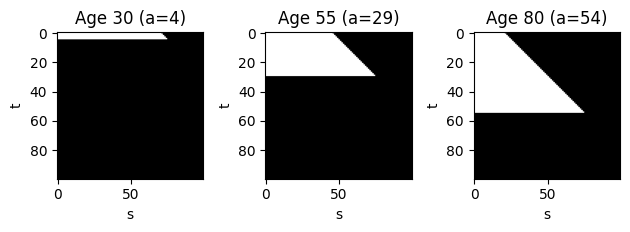

In [13]:
ages = [30, 55, 80]

fig, axs = plt.subplots(1, len(ages))
for i, age in enumerate(ages):
    axs[i].imshow(
        np.abs(age_fn_mats['tax_rate']['c'][age - age_vec[0], :100, :100])>0,
        cmap='gray',
    )
    axs[i].set_title(f"Age {age} (a={age-age_vec[0]})")
    axs[i].set_xlabel("s")
    axs[i].set_ylabel("t")
fig.tight_layout()


## Finding Aggregate Jacobians

We can find and inspect aggregate Jacobians using age-specific Jacobians, given that we know
$$\mathcal{J} = \sum_{a=0}^{A-1} \mathcal{J}[a].$$
This amounts to to summing up the age-specific Jacobians we calculated along their first dimension (age).

Aggregate Jacobians are what will end up mattering for the interactions between the household sector and the rest of the economy.

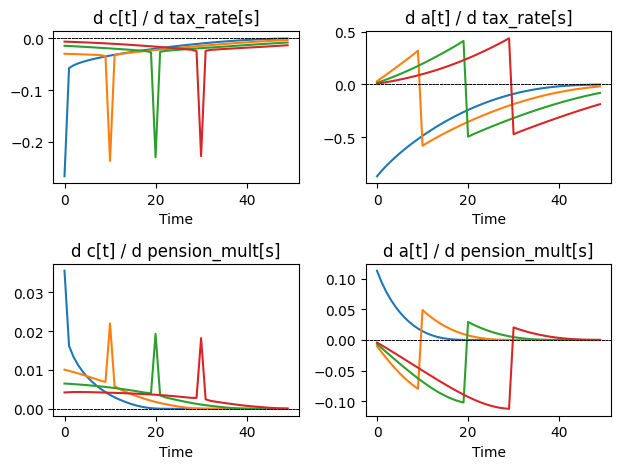

In [14]:
# Sum jacs over the age dimension to get aggregate jacobians.
agg_jacs = {
    input : {
        output : np.sum(J, axis=0) for output, J in jacs.items()
    } for input, jacs in age_jacs.items()
}

# Plot aggregate Jacobians
cols = [0, 10, 20, 30]
plot_tmax = 50
fig, ax = plt.subplots(len(agg_inputs), len(outs))
for i, input in enumerate(agg_inputs):
    for j, output in enumerate(outs):
        for c in cols:
            ax[i, j].plot(agg_jacs[input][output][:plot_tmax, c])
            ax[i, j].axhline(0, color='black', lw=0.5, ls='--')
        ax[i, j].set_title(f"d {output}[t] / d {input}[s]")
        ax[i, j].set_xlabel("Time")
fig.tight_layout()
plt.show()

Aggregate Jacobians have usual and intuitive shapes. Higher taxes generate lower consumption and higher pensions generate higher consumption.

## Aggregate Responses to Shocks (without equilibrium)

Jacobians let us easily approximate the response of the household sector to changes in inputs.

For example, imagine that the government decides to temporarily increase pensions, changing $\phi$ by an amount that geometrically decays over time. This could approximate, for example, an instantaneous nominal increase that progressively dilutes with inflation. Imagine also that, to partially finance this increase, the government implements a temporary tax increase that lasts only for two years.

We first define our shocks as sequences $(d\,\tau, d\,\phi)\equiv\{\tau_t - \tau_{ss}, \phi_t - \phi_{ss}\}_{t=0}^H$. Then the sequence-space linearization logic tells us that the dynamic response of consumption to these changes is, to first order,
\begin{equation*}
    d\, C = \mathcal{J}^{C,\tau} d\, \tau + \mathcal{J}^{C,\phi} d \, \phi
\end{equation*}

The next cell declares the shock sequences, finds the response of aggregate consumption and assets using the linearized formula, and plots those responses.

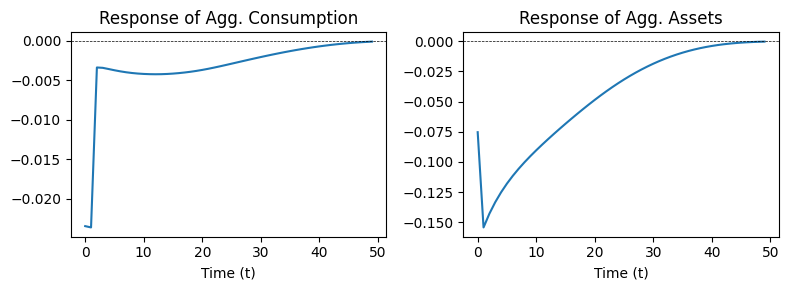

In [15]:
shocks = {
    # Create the pension shock. Assume a 10% bump that declines by 20% per year.
    "pension_mult" : 0.10 * (0.8 ** np.arange(T)),
    # Create the tax rate shock. Assume a 10 p.p. bump that lasts for two years.
    "tax_rate" : 0.10 * (np.arange(T) < 2)
}

# Responses
agg_responses = {
    out : sum([agg_jacs[input][out] @ shocks[input] for input in agg_inputs])
    for out in outs
}

# Plot aggregate responses
labels = {
    'c' : 'Consumption',
    'a' : 'Assets',
}
fig, ax = plt.subplots(1, len(outs), figsize=(8, 3))
for i, out in enumerate(outs):
    ax[i].plot(agg_responses[out][:plot_tmax])
    ax[i].axhline(0, color='black', lw=0.5, ls='--')
    ax[i].set_title(f"Response of Agg. {labels[out]}")
    ax[i].set_xlabel("Time (t)")
fig.tight_layout()

## Cohort Jacobians and Responses

Age-specific Jacobians represent the responses of a given (fixed) age-group over time. Thus, if we computed $\sum_{x}\mathcal{J}^{Y,x}(a)d\,x$ we would get the response of households of age $a$ at time $0$, then of a different cohorts of households of age $a$ at time 1, yet a different cohort of age $a$ at time $2$ and so on. This definition of age specific Jacobians helps with the derivation of our method because there is always the same set of age groups in an OLG economy (which can not be said of cohorts, who enter and exit the population).

However, one might be interested in tracking the dynamic responses of a given, fixed, cohort of agents to a shock. A simple transformation of age-specific Jacobians lets us track cohort responses using the same linear math from before. The transformation comes from noting that, if we want to track the respose of a cohort that has age $a$ at time $0$ to a time-$s$ shock, we need to consider
\begin{equation*}
    \left\{ \mathcal{J}_0^s[a], \mathcal{J}_1^{s}[a+1], \mathcal{J}_2^{s}[a+2], ...  \right\}.
\end{equation*}

Thus, we just need to define "cohort Jacobians" that shuffle the rows of age-specific Jacobians adequately. The next defines a function that performs this shuffling.

In [16]:
# Cohort jacobians
def cohort_jac(age_jac):
    A = age_jac.shape[0]
    T = age_jac.shape[1]

    # Dims are: cohort, time, s
    # with cohorts indexed by their age at time 0.
    c_jac = np.zeros((A, A, T))
    c_jac[:, 0, :] = age_jac[:, 0, :]
    for t in range(1, A):
        c_jac[:(-t), t, :] = age_jac[t:, t, :]

    return c_jac

And we can construct "cohort" Jacobians from the age-specific Jacobians that we had.

In [17]:
coh_jacs =  {
    input : {
        output : cohort_jac(J) for output, J in jacs.items()
    } for input, jacs in age_jacs.items()
}
# The cohort Jacobians run only until time t=A-1, because then
# the last cohort that was alive at the time of the shock dies.
print("Cohort Jacobians have shape", coh_jacs['tax_rate']['c'].shape)

Cohort Jacobians have shape (75, 75, 200)


The same linear logic from before applies. To get the dynamic response of a cohort, we multiply the shocks by its Jacobians and add them up.

The next cell finds the response of all the cohorts that were alive at the time of the shock announcement (0).

In [18]:
# Get the response of every cohort, mutiplying Jacs by shocks
coh_c_resp = sum(
    [coh_jacs[input]['c'] @ shocks[input] for input in agg_inputs]
)
# Dimensions = (Cohort, Time)
print("Cohort responses have shape", coh_c_resp.shape)

Cohort responses have shape (75, 75)


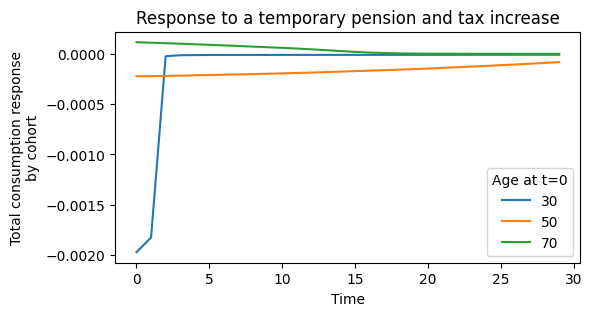

In [19]:
# Plot the response of different cohorts
ages = [30,50,70]
age_inds = [a - age_vec[0] for a in ages]
t_max_plot = 30
plt.figure(figsize=(6, 3))
for ai in age_inds:
    plt.plot(coh_c_resp[ai, :t_max_plot], label=str(age_vec[ai]))

plt.xlabel("Time")
plt.ylabel("Total consumption response\nby cohort")
plt.legend(title="Age at t=0")
plt.title("Response to a temporary pension and tax increase")
plt.show()

The responses make sense:
- Retirees are better-off on net with their higher pensions and they increase ther consumption.
- Middle aged households (age 50) are adversely affected by tax increases and pensions that will have decayed a lot by the time they retire. However, they have some savings to smooth out the effect of the tax increase over time.
- Young households do not have much savings to respond to the tax increase and so they have to sharply reduce their consumption while it lasts (the first two years).

# Equilibirum Responses to Shocks Using the `Sequence-Jacobian` Toolkit

Our previous demonstration made completely ad-hoc assumptions about how taxes would respond to the increase in pensions.

Ideally, we would pair our household block with a more sophisticated fiscal block. For example, imagine that the government changes the tax rate to keep its deficit constant. To make things interesting, assume that households save in government bonds so that interests on household savings enter the government deficit. Assume also that the interest rate on the debt is exogenous. Then, we have the restriction
\begin{equation*}
    \text{Taxes}(\tau_t) - \text{Pensions}(\phi_t) - r\times B_t = \text{Constant}.
\end{equation*}

How can we figure out the sequence of taxes $\{\tau_t\}_{t=0}^H$ that satisfies this restriction for a given path of pensions? The total level of taxes and pensions in the economy are easy enough objects to think about because households induce no endogenous movements in them. The difficult object in this restriction is $B_t$: household savings are a non-linear function past, present, and future taxes and pensions. The `sequence-jacobian` toolkit lets us solve this problem.

The next cell loads it and defines two model blocks:
- The first produces the level of our pension multiplier for a given level of pension shock.
- The second calculates the residual in our deficit restriction given a level of aggregate net transfers (pensions minus taxes), household savings, and interest rates.

In [20]:
import sequence_jacobian as ssj

@ssj.simple
def pensions(pension_shock):
    pension_mult = 1.0 + pension_shock
    return pension_mult

@ssj.simple
def fiscal_target(net_transf, a, R):
    deficit = net_transf + (R - 1.0) * a
    fiscal_resid = deficit  - (net_transf.ss + (R.ss - 1.0) * a.ss)
    return fiscal_resid

The next step is to define our household block in a format that the `sequence-jacobian` package understands. We do this using the package's `JacobianDict` object, which constructs block representations from simple dictionaries that contains the Jacobians of all their input-output pairs.

We have to recalculate the Jacobians, however, because we need one more output from the household block: "net transfers", which are the difference between pensions and taxes.

All that is done in the next cell.

In [21]:
# Add the new output and recalculate Jacobians
outs = outs + ['net_transf']
age_jacs = {}
for shk_param in agg_inputs:
    t0 = time()
    age_jacs[shk_param], _ = fake_news_jacobian(
        agent=agent,
        shk_param=shk_param,
        outcome_fns=outs,
        newborn_dstn=nb_dstn,
        horizon=T,
        dx=dx,
        verbose=False,
    )
    print("Calculating jacobians for " + shk_param + " took: " + str(time() - t0) + " seconds")

# Create JacobianDict object

# Get aggregate jacobians again. Also reorganize them because the ssj
# package expects the top level of the dictionary to be the outputs, and the second
# level to be the inputs.
agg_jacs = {
    output: {
        input: np.sum(J[output], axis=0) for input, J in age_jacs.items()
    } for output in outs
}

# Now we can create the JacobianDict object.
J_hh = ssj.JacobianDict(
    agg_jacs,
    T=T,
    name='Household'
)
# and inspect it
print(J_hh)

Calculating jacobians for tax_rate took: 1.2909936904907227 seconds
Calculating jacobians for pension_mult took: 1.2217910289764404 seconds
<JacobianDict outputs=['c', 'a', 'net_transf'], inputs=['tax_rate', 'pension_mult']>


The next step is to combine the different blocks that we have created into a model.

In [22]:
dag = ssj.create_model([J_hh, pensions, fiscal_target], name='OLG-Fiscal')
print(dag)

<Model 'OLG-Fiscal'>


The next step is to construct a dictionary with the steady state values of the variables in our model. The next cell does that.

Some variables (the interest rate, the steady state value of taxes and pensions) we can just grab from the parameters of the household block. For others, like the steady state level of household savings and net transfers, we actually have to aggregate the steady state distribution and policy functions of the household block

In [23]:
# Start by aggregating the household outputs
ss_dstn = agent.transitions.find_steady_state_dstn()
points = agent.get_outcomes(outs)
ss = {
    key : sum([(y*d).sum() for y, d in zip(out_points, ss_dstn)])
    for key, out_points in points.items()
}

# Now add inputs and constants from the calibration
ss.update({
    'pension_mult' : params['pension_mult'],
    'tax_rate' : params['tax_rate'],
    'pension_shock' : 0.0,
    'R' : params['R'],
})

# Finally, declare as a `SteadyStateDict` object that the toolbox understands
ss = ssj.SteadyStateDict(ss)
# And inspect
ss.toplevel

{'c': np.float64(0.8036972502584568),
 'a': np.float64(1.2288210510345936),
 'net_transf': np.float64(-0.12890691768891707),
 'pension_mult': 1.0,
 'tax_rate': 0.3,
 'pension_shock': 0.0,
 'R': 1.02}

Now we can solve for the "general equilibrium Jacobians" ``G.'' These are objects that contain the effects of shocks on endogenous variables, taking into account the equilibrium restrictions that we impose.

The `sequence-jacobian` toolbox calculates these objects for us. We just need to define three sets of variables:
- `exogenous` variables: in our case, the pension shock.
- `targets`: the variables that must be zero in equilibrium; in our case the fiscal residual.
- `unknowns`: the endogenous variables that must move to satisfy equilibrium restrictions in response to shocks; the tax rate in our case.

We must have the same number of targets and unknowns.

The next cell gets the general equilibrium Jacobian.

In [24]:
unknowns = ['tax_rate']
targets = ['fiscal_resid']
exogenous = ['pension_shock']
dag.blocks

# Solve for GE jacobian
G = dag.solve_jacobian(ss, unknowns, targets, exogenous, T=T)
print(G)

<JacobianDict outputs=['tax_rate', 'c', 'a', 'net_transf', 'pension_mult', 'fiscal_resid'], inputs=['pension_shock']>


We can calculate the equilibrium response to the same pension shock we had before.

In [25]:
# Apply the pension shock
pension_shock = shocks['pension_mult']
td = G.apply({'pension_shock': pension_shock})

# Check that we got an endogenous tax response
print('Tax changes (to year 5):', td['tax_rate'][:5])

# And that the fiscal residual is zero
print(f"Max absolute fiscal residual: {np.max(np.abs(td['fiscal_resid'])):0.2e}")

Tax changes (to year 5): [0.01300087 0.01033322 0.00819342 0.00647716 0.00510089]
Max absolute fiscal residual: 2.78e-18


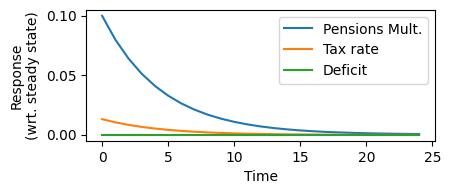

In [26]:
# Plot the shock, target, and endogenous tax response
t_plot = 25
fig = plt.figure(figsize=(4.5, 1.7))
plt.plot(td['pension_mult'][:t_plot], label='Pensions Mult.')
plt.plot(td['tax_rate'][:t_plot], label='Tax rate')
plt.plot(td['fiscal_resid'][:t_plot], label='Deficit')
plt.xlabel('Time')
plt.ylabel('Response\n(wrt. steady state)')
plt.legend()
plt.show()

if export_plots:
    fig.tight_layout()
    fig.savefig(plot_dir + "GE_pension_agg.pdf")

### Equilibrium responses of different cohorts

Like before, we can use the age-specific Jacobians to find the responses of different cohorts. The difference now is that the path of the tax rate change satisfies the restriction we imposed on the government deficit.

In [27]:
# Consumption response of different cohorts
coh_c_resp = sum(
    [np.dot(coh_jacs[inp]['c'], td[inp]) for inp in ['tax_rate', 'pension_mult']]
)

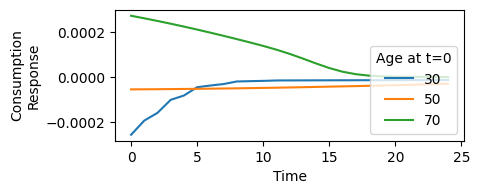

In [28]:
# Plot the total response of different cohorts
fig = plt.figure(figsize=(4.5, 1.7))
for a in ages:
    plt.plot(coh_c_resp[a - age_vec[0], :t_plot], label=str(a))
plt.xlabel("Time")
plt.ylabel("Consumption\nResponse")
plt.legend(title="Age at t=0", loc='lower right')
plt.show()

if export_plots:
    fig.tight_layout()
    fig.savefig(plot_dir + "GE_pension_coh.pdf")

### How do the mechanisms change across the life cycle?

Now suppose we want to dig deeper and ask exactly why each of the cohorts respond in the way that they do. Only two things that are exogenous to the household block are changinng: pensions and taxes. Furthermore, since we are using linear approximations, the total response is the sum of the response to pensions and the response to taxes. The time-0 response of households of age $a$ is
\begin{equation*}
    d C_0(a) = \underbrace{\mathcal{J}^{C,\tau}_{[0,:]}(a) d \vec{\tau}}_{\text{Resp. to taxes}} + \underbrace{\mathcal{J}^{C,\phi}_{[0,:]}(a) d \vec{\phi}}_{\text{Resp. to pensions}}
\end{equation*}


Text(0, 0.5, 'dC_0/Css')

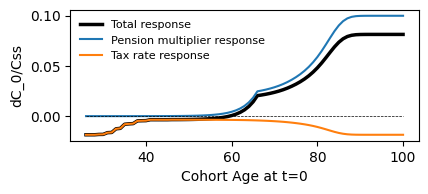

In [29]:
c_0_decomp = {
    name : age_jacs[name]['c'][:, 0, :] @ td[name] for name in ['tax_rate', 'pension_mult']
}

# Get the age-specific steady state consumption to express as percentage
c_ss = np.array(
    [np.sum(d*c) for d, c in zip(ss_dstn, out_points['c'])]
)[:-1]

# Plot the decomposition of the initial consumption response
# as an area plot with stacking mechanisms
fig, ax = plt.subplots(1,1,figsize=(4.5, 1.7))
ax.plot(
    age_vec, (c_0_decomp['pension_mult'] + c_0_decomp['tax_rate']) / c_ss, 
    label='Total response',
    linewidth=2.5,
    color='black',
)
ax.plot(
    age_vec, c_0_decomp['pension_mult'] / c_ss,
    label='Pension multiplier response',
)
ax.plot(
    age_vec, c_0_decomp['tax_rate'] / c_ss,
    label='Tax rate response',
)
ax.hlines(
    0, age_vec[0], age_vec[-1], color='black', lw=0.5, ls='--'
)
ax.legend(loc='upper left', fontsize=8, frameon=False)
ax.set_xlabel('Cohort Age at t=0')
ax.set_ylabel('dC_0/Css')
